# Freesolv Optimized vs Unoptimized Extraction/Postprocessing/Comparison
1. load and process the charge-optimized resimulated AHFEs along with the charge-optimized reweighted charge-optimized AHFEs to correlate them.
2. save the charge-optimized AHFEs to `agg_freesolv_ixn_data.t5.pkl`
3. analyze the correlation of charge-optimized resimulated AHFEs with experimental data and compute/plot residual CDFs. Do the same with Unoptimized/

In [1]:
import os
import pickle
import typing
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 12  # Set default font size to 12

from timemachine.datasets.utils import fetch_freesolv
from timemachine.fe.utils import get_mol_name
from timemachine.fe.refitting import query_name_dG_dG_err, load_pkl_data #, ligand_charges_from_solvent_res, es_ss_qs_hs_from_mol_graph, embedding_pca
#from timemachine.ff import make_mol_omm_sys
from timemachine.constants import KCAL_TO_KJ
from timemachine.fe.refitting import BETA
from scipy import stats


# esp stuff
# import torch
# import espaloma as esp

import scipy
import sklearn.metrics
from typing import Union

from openff.toolkit.topology import Molecule

# esp_model = esp.get_model("latest")

The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html
The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html


In [2]:
def bootstrap_statistic(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    dy_true: Union[np.ndarray, None] = None,
    dy_pred: Union[np.ndarray, None] = None,
    ci: float = 0.95,
    statistic: str = "RMSE",
    nbootstrap: int = 1000,
    plot_type: str = "dG",
    include_true_uncertainty: bool = False,
    include_pred_uncertainty: bool = False,
) -> dict:

    """Compute mean and confidence intervals of specified statistic.

    Parameters
    ----------
    y_true : ndarray with shape (N,)
        True values
    y_pred : ndarray with shape (N,)
        Predicted values
    dy_true : ndarray with shape (N,) or None
        Errors of true values. If None, the values are assumed to have no errors
    dy_pred : ndarray with shape (N,) or None
        Errors of predicted values. If None, the values are assumed to have no errors
    ci : float, optional, default=0.95
        Interval for confidence interval (CI)
    statistic : str
        Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','KTAU','RAE']
    nbootstrap : int, optional, default=1000
        Number of bootstrap samples
    plot_type : str, optional, default='dG'
        'dG' or 'ddG'
    include_true_uncertainty : bool, default False
        whether to account for the uncertainty in y_true when bootstrapping
    include_pred_uncertainty : bool, default False
        whether to account for the uncertainty in y_pred when bootstrapping

    Returns
    -------
    rmse_stats : dict of float
        'mean' : mean RMSE
        'stderr' : standard error
        'low' : low end of CI
        'high' : high end of CI
    """

    def compute_statistic(y_true_sample: np.ndarray, y_pred_sample: np.ndarray, statistic: str):
        """Compute requested statistic.

        Parameters
        ----------
        y_true : ndarray with shape (N,)
            True values
        y_pred : ndarray with shape (N,)2
            Predicted values
        statistic : str
            Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','RAE','KTAU']

        """

        def calc_RAE(y_true_sample: np.ndarray, y_pred_sample: np.ndarray):
            MAE = sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
            mean = np.mean(y_true_sample)
            MAD = np.sum([np.abs(mean - i) for i in y_true_sample]) / float(len(y_true_sample))
            return MAE / MAD

        def calc_RRMSE(y_true_sample: np.ndarray, y_pred_sample: np.ndarray):
            rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample))
            mean_exp = np.mean(y_true_sample)
            mds = np.sum([(mean_exp - i) ** 2 for i in y_true_sample]) / float(len(y_true_sample))
            rrmse = np.sqrt(rmse**2 / mds)
            return rrmse

        if statistic == "RMSE":
            return np.sqrt(sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample))
        elif statistic == "MUE":
            return sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
        elif statistic == "R2":
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
                y_true_sample, y_pred_sample
            )
            return r_value**2
        elif statistic == "rho":
            return scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]
        elif statistic == "RAE":
            return calc_RAE(y_true_sample, y_pred_sample)
        elif statistic == "KTAU":
            return scipy.stats.kendalltau(y_true_sample, y_pred_sample)[0]
        else:
            raise Exception("unknown statistic '{}'".format(statistic))

    # not used?
    def unique_differences(x):
        """Compute all unique differences"""
        N = len(x)
        return np.array([(x[i] - x[j]) for i in range(N) for j in range(N) if (i != j)])

    if dy_true is None:
        dy_true = np.zeros_like(y_true)
    if dy_pred is None:
        dy_pred = np.zeros_like(y_pred)
    assert len(y_true) == len(y_pred)
    assert len(y_true) == len(dy_true)
    assert len(y_true) == len(dy_pred)
    sample_size = len(y_true)
    s_n = np.zeros(
        [nbootstrap], np.float64
    )  # s_n[n] is the statistic computed for bootstrap sample n
    for replicate in range(nbootstrap):
        y_true_sample = np.zeros_like(y_true)
        y_pred_sample = np.zeros_like(y_pred)
        for i, j in enumerate(
            np.random.choice(np.arange(sample_size), size=[sample_size], replace=True)
        ):
            stddev_true = np.fabs(dy_true[j]) if include_true_uncertainty else 0
            stddev_pred = np.fabs(dy_pred[j]) if include_pred_uncertainty else 0
            y_true_sample[i] = np.random.normal(loc=y_true[j], scale=stddev_true, size=1)[0]
            y_pred_sample[i] = np.random.normal(loc=y_pred[j], scale=stddev_pred, size=1)[0]
        s_n[replicate] = compute_statistic(y_true_sample, y_pred_sample, statistic)

    rmse_stats = dict()
    rmse_stats["mle"] = compute_statistic(y_true, y_pred, statistic)
    rmse_stats["stderr"] = np.std(s_n)
    rmse_stats["mean"] = np.mean(s_n)
    # TODO: Is there a canned method to do this?
    s_n = np.sort(s_n)
    low_frac = (1.0 - ci) / 2.0
    high_frac = 1.0 - low_frac
    rmse_stats["low"] = s_n[int(np.floor(nbootstrap * low_frac))]
    rmse_stats["high"] = s_n[int(np.ceil(nbootstrap * high_frac))]

    return rmse_stats


In [3]:
# this might have to change...
ixn_pickle_path = '/data1/choderaj/rufad/tm/freesolv_esp_ixn'

all_freesolv_mols = fetch_freesolv()
len(all_freesolv_mols)

# extract data to a single set of lists
out_names, out_exp_dGs, out_calc_dGs = [], [], [] # es, ss, hs, etc are unnecessary as they are the same as the orig freesolv data
for idx, mol in enumerate(all_freesolv_mols):
    name, dG, dG_err = query_name_dG_dG_err(mol) # think these are in kcal/mol
    my_pkl_name = f"success_ahfe_result_{name}_ixn.t5.pkl"
    my_file = os.path.join(ixn_pickle_path, my_pkl_name)
    try:
        data = load_pkl_data(my_file) # use the function instead
    except Exception as e:
        print(e, idx)
        continue
    # pull data
    solvent_res, prefactors0, prefactors1 = data
    # protocol goes from 0 (decoupled) to 1 (coupled):
    # https://github.com/dominicrufa/timemachine/blob/30261bf1bb8bf4d77d90b814913b34dc463f6795/timemachine/fe/absolute_hydration.py#L162
    solvent_dg = sum(solvent_res.final_result.dGs) / KCAL_TO_KJ
    solvent_dg_err = np.linalg.norm(solvent_res.final_result.dG_errs) / KCAL_TO_KJ
    
    out_names.append(name)
    out_calc_dGs.append([solvent_dg, solvent_dg_err])
    out_exp_dGs.append([dG, dG_err])    

[Errno 2] No such file or directory: '/data1/choderaj/rufad/tm/freesolv_esp_ixn/success_ahfe_result_mobley_1929982_ixn.t5.pkl' 77
[Errno 2] No such file or directory: '/data1/choderaj/rufad/tm/freesolv_esp_ixn/success_ahfe_result_mobley_2146331_ixn.t5.pkl' 100
[Errno 2] No such file or directory: '/data1/choderaj/rufad/tm/freesolv_esp_ixn/success_ahfe_result_mobley_2725215_ixn.t5.pkl' 147
[Errno 2] No such file or directory: '/data1/choderaj/rufad/tm/freesolv_esp_ixn/success_ahfe_result_mobley_2996632_ixn.t5.pkl' 176
[Errno 2] No such file or directory: '/data1/choderaj/rufad/tm/freesolv_esp_ixn/success_ahfe_result_mobley_3425174_ixn.t5.pkl' 214
[Errno 2] No such file or directory: '/data1/choderaj/rufad/tm/freesolv_esp_ixn/success_ahfe_result_mobley_3762186_ixn.t5.pkl' 236


KeyboardInterrupt: 

In [ ]:
arr_exp_dGs = np.array(out_exp_dGs)
arr_calc_dGs = np.array(out_calc_dGs)

In [6]:
with open(f"agg_freesolv_ixn_data.t5.pkl", "wb") as fh:
    pickle.dump((out_names, arr_exp_dGs, arr_calc_dGs), fh)

in order to distinguish what is training/testing, i need to first load the refitting data so I can extract training/testing indices;
The indices are w.r.t. the original freesolv names (of calcs that completed).

In [3]:
out_names, arr_exp_dGs, arr_calc_dGs = load_pkl_data(f"agg_freesolv_ixn_data.t5.pkl")

In [4]:
# querying reweighting expts with the corresponding dataset to which `freesolv_esp_ixn` was used.
num_pcs, retrieve_by_descent, train_fraction, use_ml = 100, False, 0.75, False # hardcode this as our template optimized params to use.
use_ESS = True
refit_data_pkl = f"/data1/choderaj/rufad/tm/{num_pcs}_{retrieve_by_descent}_{train_fraction}_{use_ml}_{use_ESS}.t5.freesolv.pkl"

refit_data = load_pkl_data(refit_data_pkl)
[(res, callback_calls), params, train_loss_auxs, test_loss_auxs, validate_loss_auxs, train_idxs, test_idxs, validate_idxs, cache] = refit_data
train_idxs = list(train_idxs)
test_idxs = list(test_idxs)
validate_idxs = list(validate_idxs)

In [5]:
# load the original freesolv data.
agg_orig_freesolv_filepath = '/data1/choderaj/rufad/tm/agg_freesolv_data.pkl'
agg_orig_freesolv_data = load_pkl_data(agg_orig_freesolv_filepath)
(orig_out_names, orig_arr_exp_dGs, orig_arr_calc_dGs, prefactors, ligand_charges, es, ss, hs) = agg_orig_freesolv_data

# load the new freesolv data (so this can stand alone as a code snippet)
(ixn_out_names, ixn_arr_exp_dGs, ixn_arr_calc_dGs) = load_pkl_data(f"agg_freesolv_ixn_data.t5.pkl")

In [6]:
# train/test/validate loss auxs (must be converted to kcal/mol, see next cell)
(tr_ESS, tr_delta_us, tr_orig_calc_dg, 
 tr_reweighted_solv_dg, tr_reweighted_solv_ddg, 
 tr_exp_dg, tr_ligand_tm_charges, tr_orig_es_ss, tr_mod_es_ss) = train_loss_auxs

(te_ESS, te_delta_us, te_orig_calc_dg, 
 te_reweighted_solv_dg, te_reweighted_solv_ddg, 
 te_exp_dg, te_ligand_tm_charges, te_orig_es_ss, te_mod_es_ss) = test_loss_auxs

(vl_ESS, vl_delta_us, vl_orig_calc_dg, 
 vl_reweighted_solv_dg, vl_reweighted_solv_ddg, 
 vl_exp_dg, vl_ligand_tm_charges, vl_orig_es_ss, vl_mod_es_ss) = validate_loss_auxs

In [7]:
# since the number of original and ixn freesolv calc datapoints are mismatched and only aligned by mol_names
# i need to make a lookup to query the appropriate idxs in the new ixn dataset
orig_to_ixn_idx = {}
for orig_idx, orig_name in enumerate(orig_out_names):
    try:
        ixn_idx = ixn_out_names.index(orig_name)
        orig_to_ixn_idx[orig_idx] = ixn_idx
    except Exception as e:
        continue
ixn_to_orig_idx = {val: key for key, val in orig_to_ixn_idx.items()}

# idxs tolists


# now get dg, ddg maps
corr_calc_dgs = [[], [], []]
# for each train/test/validate set, record orig_dg, orig_ddg, rew_dg, rew_ddg, ixn_dg, ixn_ddg, exp_dg, exp_ddg (all in kcal/mol)


for ixn_idx, orig_idx in ixn_to_orig_idx.items():
    ixn_dg, ixn_ddg = ixn_arr_calc_dGs[ixn_idx] # in kcal/mol
    orig_dg, orig_ddg = orig_arr_calc_dGs[orig_idx] # in kcal/mol
    (ixn_exp_dg, ixn_exp_ddg), orig_exp_dg = ixn_arr_exp_dGs[ixn_idx], orig_arr_exp_dGs[orig_idx, 0]
    assert np.isclose(ixn_exp_dg, orig_exp_dg)
    if orig_idx in train_idxs:
        _inner_idx = train_idxs.index(orig_idx)
        rew_dg, rew_ddg = tr_reweighted_solv_dg[_inner_idx], tr_reweighted_solv_ddg[_inner_idx]
        set_idx = 0
    elif orig_idx in test_idxs:
        _inner_idx = test_idxs.index(orig_idx)
        rew_dg, rew_ddg = te_reweighted_solv_dg[_inner_idx], te_reweighted_solv_ddg[_inner_idx]
        set_idx = 1
    else:
        _inner_idx = validate_idxs.index(orig_idx)
        rew_dg, rew_ddg = vl_reweighted_solv_dg[_inner_idx], vl_reweighted_solv_ddg[_inner_idx]
        set_idx = 2
    
    corr_calc_dgs[set_idx].append([orig_dg, orig_ddg, 
                                   rew_dg / BETA / KCAL_TO_KJ, rew_ddg / BETA / KCAL_TO_KJ,
                                  ixn_dg, ixn_ddg,
                                  ixn_exp_dg, ixn_exp_ddg])

combined_dgs = [np.array(q) for q in corr_calc_dgs]

In [8]:
ixn_dgs, ixn_ddgs = np.concatenate([q[:,4] for q in combined_dgs]), np.concatenate([q[:,5] for q in combined_dgs])
rew_dgs, rew_ddgs = np.concatenate([q[:,2] for q in combined_dgs]), np.concatenate([q[:,3] for q in combined_dgs])

statistics = {'RMSE': None, 'MUE': None, 'R2': None}
for key in statistics.keys():
    _list = bootstrap_statistic(
        y_true = ixn_dgs,
        y_pred = rew_dgs,
        dy_true = ixn_dgs*0.,
        dy_pred = rew_dgs*0.,
        statistic = key,
        nbootstrap = 1000,
        plot_type = "dG",
        include_true_uncertainty = False,
        include_pred_uncertainty = False,
    )
    statistics[key] = _list


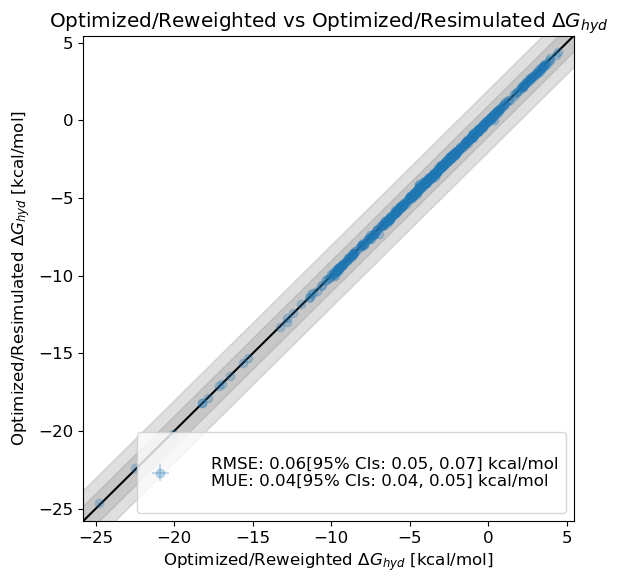

In [9]:
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, ax = plt.subplots(figsize=(6,6))

plt.errorbar(
    rew_dgs, ixn_dgs, 
    xerr = rew_ddgs, yerr = ixn_ddgs, 
    marker='o', ls='none', alpha=0.25,
    label=f"""
    RMSE: {statistics['RMSE']['mean']:.2f}[95% CIs: {statistics['RMSE']['low']:.2f}, {statistics['RMSE']['high']:.2f}] kcal/mol
    MUE: {statistics['MUE']['mean']:.2f}[95% CIs: {statistics['MUE']['low']:.2f}, {statistics['MUE']['high']:.2f}] kcal/mol
    """)

# make fill between
x = np.linspace(min(rew_dgs) - 2, max(rew_dgs) + 2, 1000)
y1 = x + 1
y2 = x - 1
plt.plot(x, x, color='k')
ax.fill_between(x, y1, y2, color='grey', alpha=0.25)
ax.fill_between(x, y1 + 1, y2 - 1, color='grey', alpha=0.25)
plt.title(r"Optimized/Reweighted vs Optimized/Resimulated $\Delta G_{hyd}$")
plt.xlim(min(rew_dgs) - 1, max(rew_dgs) + 1)
plt.ylim(min(rew_dgs) - 1, max(rew_dgs) + 1)
plt.xlabel(r"Optimized/Reweighted $\Delta G_{hyd}$ [kcal/mol]")
plt.ylabel(r"Optimized/Resimulated $\Delta G_{hyd}$ [kcal/mol]")
plt.legend()

plt.tight_layout()
plt.savefig("fig5_rew_recalc_corr.pdf", format="pdf", dpi=300)

now, I want to compute the rmse of the training/testing datasets of the original and resimulated results to try and observe an actual improvement on par with reweighting improvement.

In [10]:
orig_dgs, orig_ddgs = [q[:,0] for q in combined_dgs], [q[:,1] for q in combined_dgs]
ixn_dgs, ixn_ddgs = [q[:,4] for q in combined_dgs], [q[:,5] for q in combined_dgs]
exp_dgs, exp_ddgs = [q[:,6] for q in combined_dgs], [q[:,7] for q in combined_dgs]

0
1
2


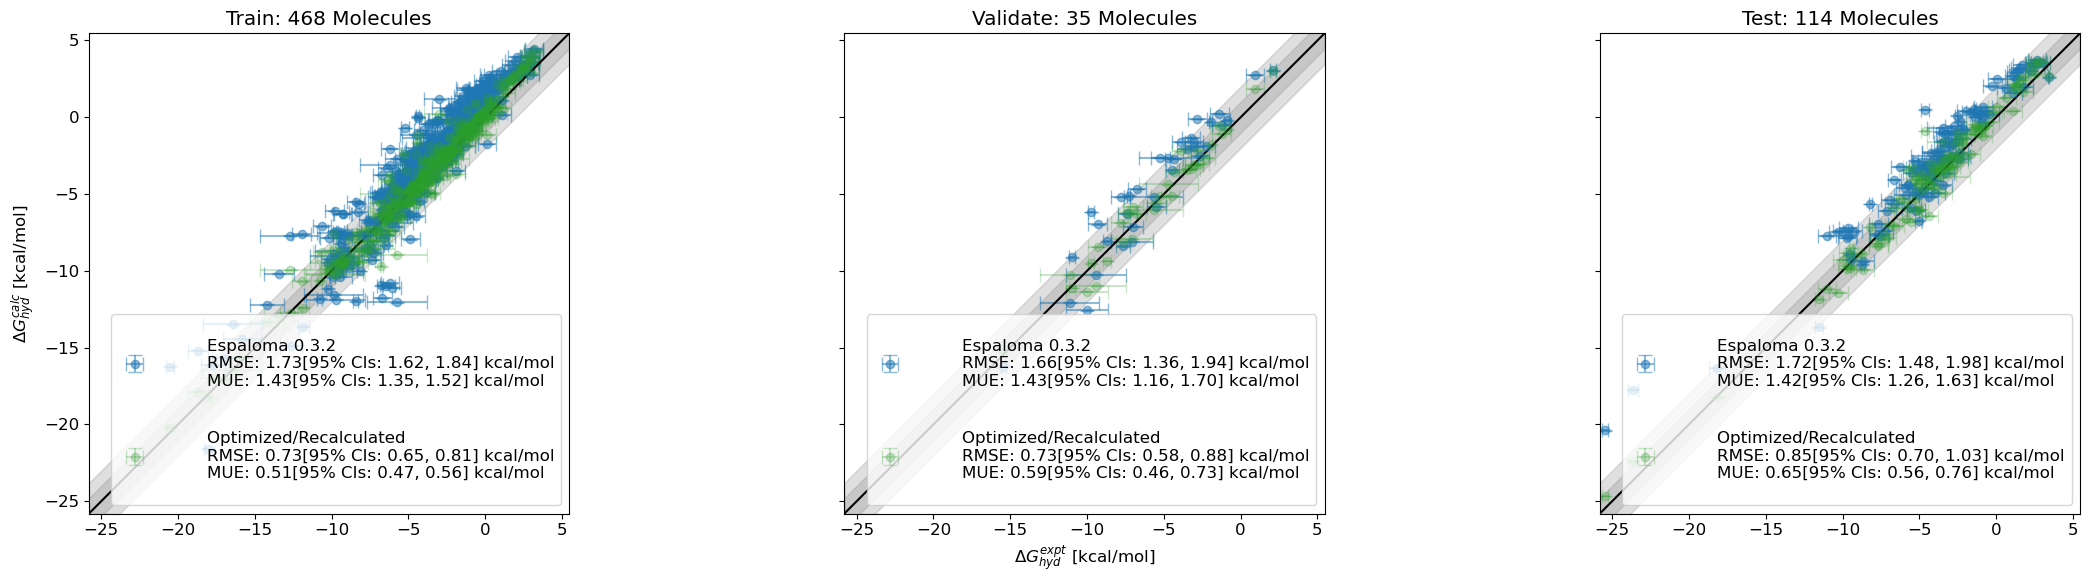

In [11]:
# just plot the original and resimulated correlated to expt (by color)
# for train/test/validate, change color; plot R2 and rmse

_label_to_idx = [0,2,1]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6), sharex=True, sharey=True)
for plt_idx, _label in enumerate(['Train', 'Validate', 'Test']):
    print(plt_idx)
    _idx = _label_to_idx[plt_idx]

    statistics = {'RMSE': None, 'MUE': None, 'R2': None}
    for key in statistics.keys():
        _list = bootstrap_statistic(
            y_true = exp_dgs[_idx],
            y_pred = orig_dgs[_idx],
            dy_true = exp_dgs[_idx]*0.,
            dy_pred = orig_dgs[_idx]*0.,
            statistic = key,
            nbootstrap = 1000,
            plot_type = "dG",
            include_true_uncertainty = False,
            include_pred_uncertainty = False,
        )
        statistics[key] = _list
    
    axes[plt_idx].errorbar(
        exp_dgs[_idx], orig_dgs[_idx], xerr = exp_ddgs[_idx], yerr = orig_ddgs[_idx], 
        ls='none', fmt='o', capsize=5, alpha=0.5, color = default_colors[0],
        label=f"""
        Espaloma 0.3.2
        RMSE: {statistics['RMSE']['mean']:.2f}[95% CIs: {statistics['RMSE']['low']:.2f}, {statistics['RMSE']['high']:.2f}] kcal/mol
        MUE: {statistics['MUE']['mean']:.2f}[95% CIs: {statistics['MUE']['low']:.2f}, {statistics['MUE']['high']:.2f}] kcal/mol
        """)

    statistics = {'RMSE': None, 'MUE': None, 'R2': None}
    for key in statistics.keys():
        _list = bootstrap_statistic(
            y_true = exp_dgs[_idx],
            y_pred = ixn_dgs[_idx],
            dy_true = exp_dgs[_idx]*0.,
            dy_pred = ixn_dgs[_idx]*0.,
            statistic = key,
            nbootstrap = 1000,
            plot_type = "dG",
            include_true_uncertainty = False,
            include_pred_uncertainty = False,
        )
        statistics[key] = _list

    axes[plt_idx].errorbar(
        exp_dgs[_idx], ixn_dgs[_idx], xerr = exp_ddgs[_idx], yerr = ixn_ddgs[_idx], 
        ls='none', fmt='o', capsize=5, alpha=0.25, color = default_colors[2],
        label=f"""
        Optimized/Recalculated
        RMSE: {statistics['RMSE']['mean']:.2f}[95% CIs: {statistics['RMSE']['low']:.2f}, {statistics['RMSE']['high']:.2f}] kcal/mol
        MUE: {statistics['MUE']['mean']:.2f}[95% CIs: {statistics['MUE']['low']:.2f}, {statistics['MUE']['high']:.2f}] kcal/mol
        """)
    
    x = np.linspace(min(rew_dgs) - 1, max(rew_dgs) + 1, 1000)
    y1 = x + 1
    y2 = x - 1
    axes[plt_idx].plot(x, x, color='k')
    axes[plt_idx].fill_between(x, y1, y2, color='grey', alpha=0.25)
    axes[plt_idx].fill_between(x, y1 + 1, y2 - 1, color='grey', alpha=0.25)
    #axes[plt_idx].set_aspect('equal', adjustable='box')  # Keep plot square
    axes[plt_idx].set_title(f"{_label}: {len(exp_dgs[_idx])} Molecules")
    axes[plt_idx].set_aspect('equal', adjustable='box')
    axes[plt_idx].legend(loc='best')
    
plt.xlim(min(rew_dgs) - 1, max(rew_dgs) + 1)
plt.ylim(min(rew_dgs) - 1, max(rew_dgs) + 1)

axes[1].set_xlabel(r"$\Delta G_{hyd}^{expt}$ [kcal/mol]")
axes[0].set_ylabel(r"$\Delta G_{hyd}^{calc}$ [kcal/mol]")
plt.tight_layout()
plt.savefig("fig5_orig_vs_recalc.pdf", format="pdf", dpi=300)
    


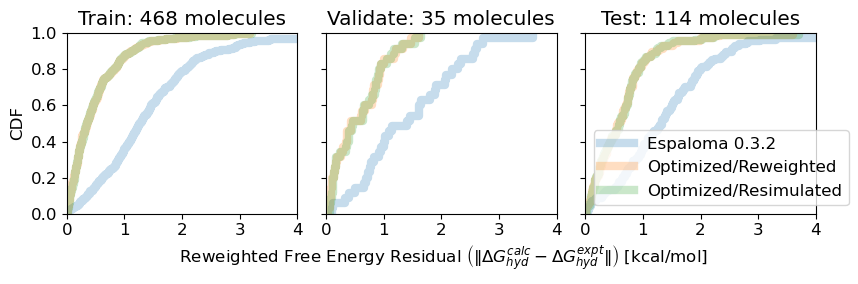

In [12]:
# lastly, show the ECDF of the train/validate/test for orig/rew/resim
# just plot the original and resimulated correlated to expt (by color)
# for train/test/validate, change color; plot R2 and rmse
orig_dgs, orig_ddgs = [q[:,0] for q in combined_dgs], [q[:,1] for q in combined_dgs]
ixn_dgs, ixn_ddgs = [q[:,4] for q in combined_dgs], [q[:,5] for q in combined_dgs]
exp_dgs, exp_ddgs = [q[:,6] for q in combined_dgs], [q[:,7] for q in combined_dgs]
rew_dgs, rew_ddgs = [q[:,2] for q in combined_dgs], [q[:,3] for q in combined_dgs]



_label_to_idx = [0,2,1]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3), sharex=True, sharey=True)
for plt_idx, _label in enumerate(['Train', 'Validate', 'Test']):
    _idx = _label_to_idx[plt_idx]
    orig_resids = np.abs(orig_dgs[_idx] - exp_dgs[_idx])
    rew_resids = np.abs(rew_dgs[_idx] - exp_dgs[_idx])
    ixn_resids = np.abs(ixn_dgs[_idx] - exp_dgs[_idx])
    axes[plt_idx].set_title(f"{_label}: {len(orig_resids)} molecules")
    axes[plt_idx].ecdf(orig_resids, color = default_colors[0], label = f"Espaloma 0.3.2", alpha = 0.25, lw=6)
    axes[plt_idx].ecdf(rew_resids, color = default_colors[1], label = f"Optimized/Reweighted", alpha = 0.25, lw=6)
    axes[plt_idx].ecdf(ixn_resids, color = default_colors[2], label = f"Optimized/Resimulated", alpha = 0.25, lw=6)
    axes[plt_idx].set_xlim(0., 4)
    # axes[plt_idx].set_aspect('equal', adjustable='box')

axes[1].set_xlabel(r" Reweighted Free Energy Residual $\left( \| \Delta G_{hyd}^{calc}  - \Delta G_{hyd}^{expt} \| \right)$ [kcal/mol]")
axes[0].set_ylabel(f"CDF")
plt.legend()    
plt.tight_layout()

plt.savefig("fig5_ecdfs.pdf", format="pdf", dpi=300)

    
